In [1]:
# Import libraries

# Utility
import os
import sys

# Wrangling
import numpy as np
import pandas as pd 

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Sklearn
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

# Torch
import torch # Main PyTorch Library
import torch.nn as nn # Submodule with neural network stuff
from torch.utils.data import TensorDataset, DataLoader

# Vizzes and metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Troubleshooting
# import os
# os.chdir("/Users/clarasmith/Sync/Fall 2025/Machine Learning/Applying_MLP")
# print(os.getcwd())  

In [3]:
# Load in datasets
df = pd.read_csv("Data/project_adult.csv")
df_val = pd.read_csv("Data/project_validation_inputs.csv")

In [4]:
# View datasets
df.head()
df_val.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


In [5]:
# Clara and Carlie
# Drop Unnamed
df = df.drop(columns=['Unnamed: 0'])

# Identify missing values
cols_with_question_mark = df.columns[df.isin(['?']).any()]
print("Columns with '?' values:")
print(cols_with_question_mark)

Columns with '?' values:
Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [6]:
# Clara and Carlie
# Count number of question mark values
question_mark_counts = (df == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])

cols_with_question_mark = df_val.columns[df_val.isin(['?']).any()]
question_mark_counts = (df_val == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         1447
occupation        1454
native-country     458
dtype: int64

Columns with at least one '?' value:
workclass         389
occupation        389
native-country    125
dtype: int64


In [7]:
# Clara and Carlie
# Replace '?' with NaN
df = df.replace('?', np.nan)

df_val = df_val.replace('?', np.nan)

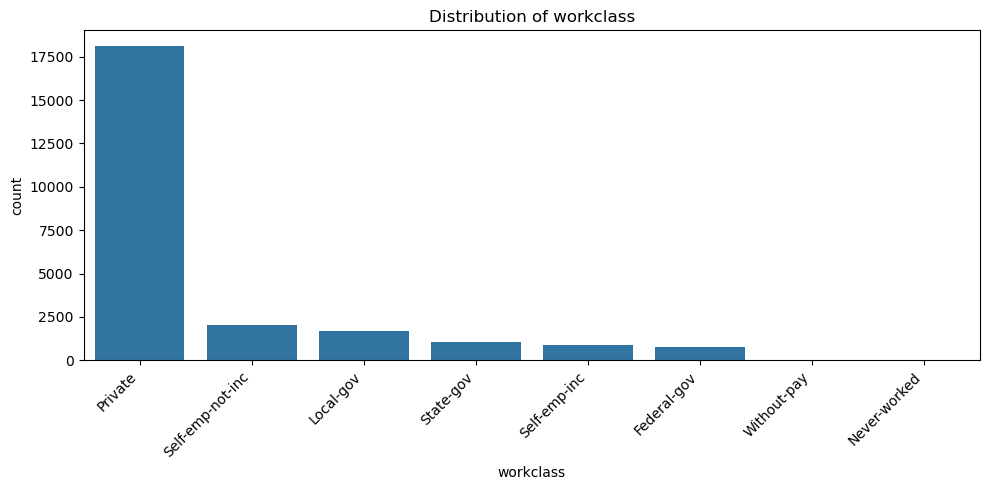

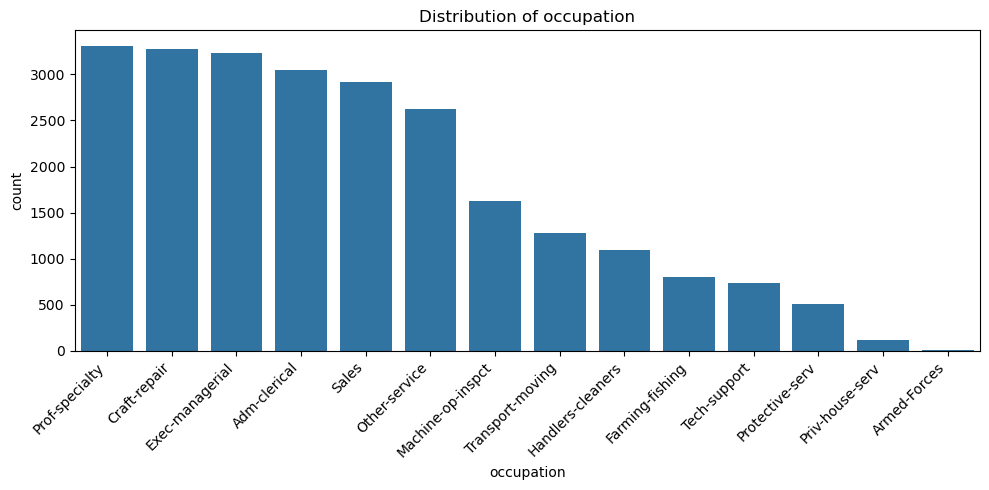

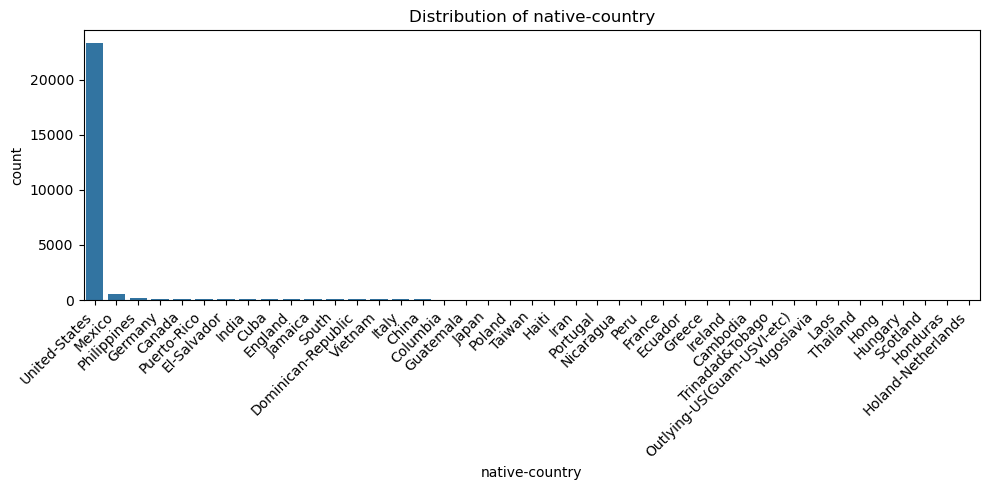

In [8]:
# Carlie

# Ploting distributions for columns with missing values
cols_to_plot = ['workclass', 'occupation', 'native-country']

for col in cols_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

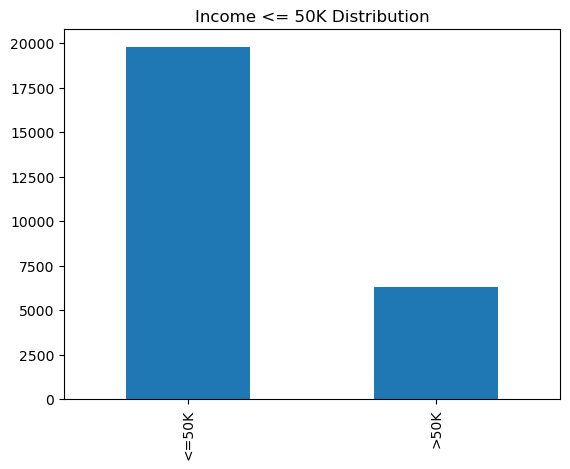

In [9]:
# Carlie
# Value counts of income that is lower than 50k
df['income'].value_counts().plot(kind='bar')
plt.title('Income <= 50K Distribution')
plt.show()


In [10]:
# Carlie
# Impute missing values in each column with its mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df_val.columns:
    df_val[col] = df_val[col].fillna(df_val[col].mode()[0])

In [11]:
# Clara and Carlie
# Encoding and spliting data

# Test = 20%
TEST_SIZE   = 0.20
RANDOM_SEED = 35

# Make a list of all categorical and numerical columns.
categorical_cols = ['workclass','education','marital-status','occupation',
                    'relationship','race','sex','native-country']
numerical_cols   = ['age','fnlwgt','education-num','capital-gain',
                    'capital-loss','hours-per-week']

# clean column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r'\s+', '-', regex=True))

# One Hot Encode categorical columns
df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns],
                    drop_first=True)

# Split features and target
X = df.drop(columns=['income'])
y = df['income'].map({">50K": 1, "<=50K": 0})

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Scale numeric columns
scaler = StandardScaler()
X_train_df[numerical_cols] = scaler.fit_transform(X_train_df[numerical_cols])
X_test_df[numerical_cols]  = scaler.transform(X_test_df[numerical_cols])

# Convert to NumPy
X_train = X_train_df.to_numpy(dtype=np.float64)
X_test  = X_test_df.to_numpy(dtype=np.float64)
y_train = y_train.to_numpy(dtype=np.int64)
y_test  = y_test.to_numpy(dtype=np.int64)


# 20838 examples/rows
# 100 features/columns
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (20838, 97), X_test: (5210, 97)
y_train: (20838,), y_test: (5210,)


In [12]:
# PyTorch model: Clara
# Begins to diverge from Carlie: outputs NumPy arrays, while .values applies only to DataFrames/Series.
# Use isinstance checks to safely convert everything to NumPy arrays.

# Convert X_train and X_test safely to numpy arrays
X_train_arr = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test_arr  = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_train_arr = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_arr  = y_test.values if isinstance(y_test, pd.Series) else y_test

# Convert to tensors
# Float32 is used to ensure easy computations and GPU handling
# We go from dataframe -> a NumPy array -> Tensor to make PyTorch happy.
# Use .view on the target to make the tensor more friendly, utilizing -1 to infer the dimensions as necessary.
# Use 1 to specify one a singular column
X_train_t = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_t = torch.tensor(y_train_arr, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test_arr, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_arr, dtype=torch.float32).view(-1, 1)

In [13]:
# Clara
# Create DataLoaders for batching
# Basically, you pair up your target labels with every feature.
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

# Batch out data utilizing dataloader.
# Divide dataset into mini-batches of 64
# Shuffle your data to ensure randomness in order

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

In [14]:
# Look at it, because why not? 
for xb, yb in train_dl: # For every feature/target in the training dataloader
    print("Features batch (xb):") # Prints the actual feature values
    print(xb)
    print("Labels batch (yb):")
    print(yb)
    print("xb shape:", xb.shape)
    print("yb shape:", yb.shape)
    break  # Don't overload the screen with a ton of print statements

# 64 represents your batch size, while the 97 represents the number of input features after the preprocessing steps.

Features batch (xb):
tensor([[-0.7784, -0.1990,  0.7423,  ...,  1.0000,  0.0000,  0.0000],
        [-1.4388,  1.9287, -0.4209,  ...,  1.0000,  0.0000,  0.0000],
        [-0.9251, -0.2328, -0.4209,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.5582,  1.3335, -0.4209,  ...,  1.0000,  0.0000,  0.0000],
        [-1.1453,  0.2682, -0.4209,  ...,  0.0000,  0.0000,  0.0000],
        [-0.8517, -0.3124, -0.0331,  ...,  1.0000,  0.0000,  0.0000]])
Labels batch (yb):
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        

In [ ]:
# Clara
# Make a little base MLP
# Based roughly on the model provided through this tutorial: https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/

class MLP(nn.Module): # Make an MLP class that inherits from nn.Module, the mother neural network model template.
    def __init__(self, input_dim): # Constructor to make an instance.
        super().__init__() # Call the parent constructor, nn.Module
        self.model = nn.Sequential( # Create your list of layers in the multilayer perceptron.
            nn.Linear(input_dim, 64), # Begin here: map to 64 neurons, learning their own weights and biases
            nn.ReLU(), # Activation: Learn complex patterns with non-linearity
            nn.Linear(64, 32), # DO IT AGAIN
            nn.ReLU(), # AND AGAIN
            nn.Linear(32, 1), # AND AGAIN (note the one output neuron for binary classification)
            nn.Sigmoid() # Take your output and squash it into an output probability between 0 and 1
        )

    def forward(self, x): # Forward layer: send the input through the self.model layers.
        return self.model(x)


In [16]:
# Initialize your model
input_dim = X_train.shape[1]
model = MLP(input_dim) # Where input_dim is your number of features, 96

# Loss function
criterion = nn.BCELoss() # The standard for binary classifications

# I was torn on using CrossEntropyLoss and BCELoss, but this Medium article helped:
# https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23

# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr=0.001 is a simpel, basal learning rate

In [17]:
# Train the model

# Define the number of epochs to work with.
epochs = 20

# Storage lists for visualization
train_losses = []
train_preds = []

for epoch in range(epochs):
    epoch_loss = 0
    for xb, yb in train_dl:
        # Forward pass
        preds = model(xb)
        
        # Save predictions for viz
        train_preds.extend(preds.detach().cpu().numpy())
        
        # Compute loss
        loss = criterion(preds, yb)
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad() # Resets all gradients of model parameters to zero
        loss.backward() # Compute gradient of the loss to update model parameters. 
        optimizer.step() # Literally update paremeters. 
    
    # Print epoch and the lsos for every epoch. Notice it decrease. 
    train_losses.append(epoch_loss / len(train_dl))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}")

# Fun fact: I've got this pretty darn memorized. The reason being this fantastic and catchy PyTorch song:
# https://www.youtube.com/watch?v=Nutpusq_AFw


Epoch 1, Loss: 0.3745
Epoch 2, Loss: 0.3144
Epoch 3, Loss: 0.3095
Epoch 4, Loss: 0.3071
Epoch 5, Loss: 0.3048
Epoch 6, Loss: 0.3032
Epoch 7, Loss: 0.3008
Epoch 8, Loss: 0.2990
Epoch 9, Loss: 0.2974
Epoch 10, Loss: 0.2951
Epoch 11, Loss: 0.2936
Epoch 12, Loss: 0.2915
Epoch 13, Loss: 0.2904
Epoch 14, Loss: 0.2887
Epoch 15, Loss: 0.2865
Epoch 16, Loss: 0.2857
Epoch 17, Loss: 0.2842
Epoch 18, Loss: 0.2815
Epoch 19, Loss: 0.2800
Epoch 20, Loss: 0.2787


In [18]:
# Clara
# Look at the test data: does it generalize? 

# Evaluation mode!
model.eval()  

# Kill the gradient computations.
with torch.no_grad():  # disable gradient computation
    # Do I really have to specify what these are? 
    y_pred = []
    y_true = []

    # For the features and targets in the test dataloader
    for xb, yb in test_dl:
        preds = model(xb) # Throw the model upon the features batch.
        y_pred.extend(preds.numpy()) # Convert preds to NumPy, and then throw in y_pred
        y_true.extend(yb.numpy()) # Same but for the target labels. 

# Convert predictions to binary (0/1)
y_pred = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true).astype(int)

# 
accuracy = (y_pred == y_true).mean() # Make a boolean array: so if the prediction matches the true label, put True, else False
print(f"Test Accuracy: {accuracy:.4f}") # Accuracy to four decimal values. 


Test Accuracy: 0.8530


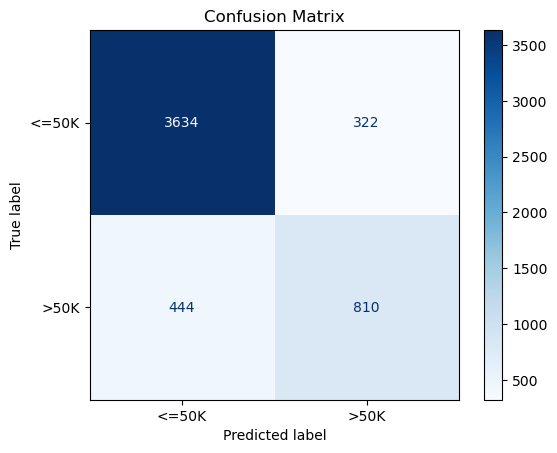

In [19]:
# Confusion matrix featuring Sklearn's confusion matrix.
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K']) # Labels
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

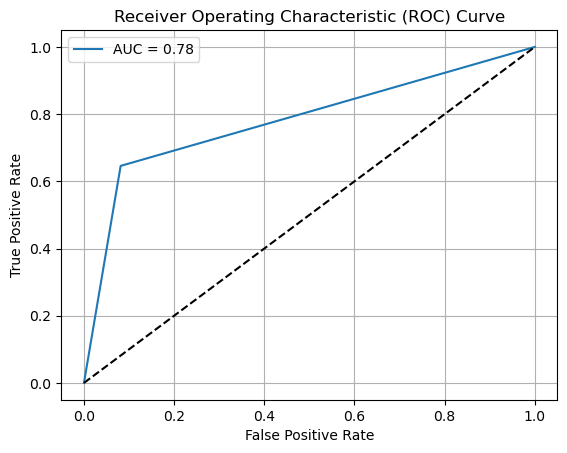

In [20]:
# Clara
# Plot the ROC curves and the AUC score
fpr, tpr, _ = roc_curve(y_true, np.array(y_pred).ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

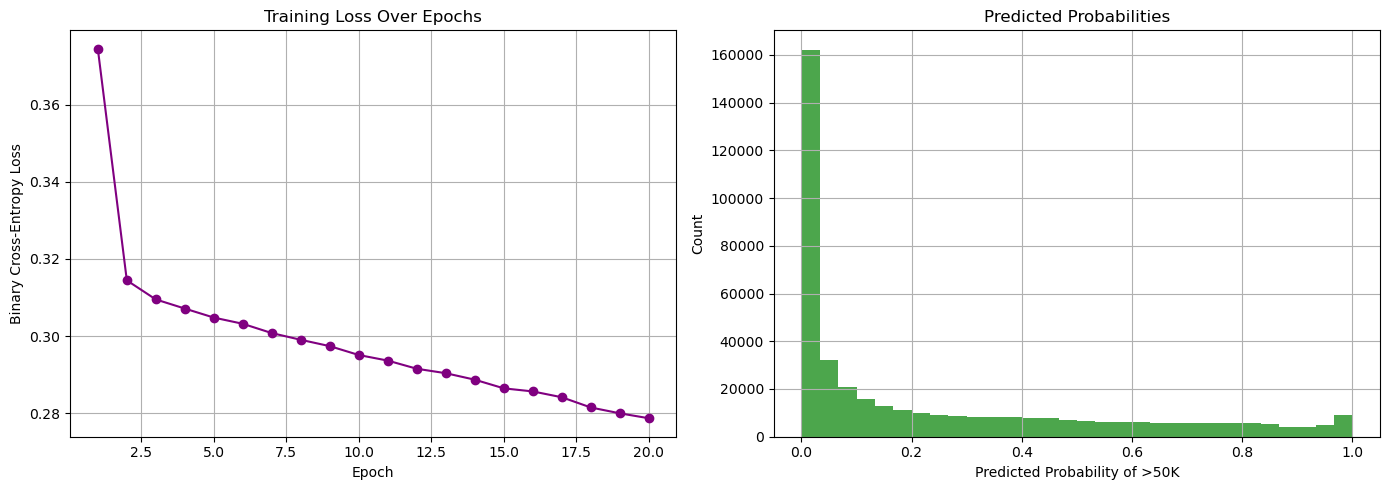

In [21]:
# Clara
fig, axs = plt.subplots(1, 2, figsize=(14,5)) # Fig of 1 row, two columns

# Training loss over epochs. Every point is a circle. 
axs[0].plot(range(1, len(train_losses)+1), train_losses, marker='o', color='purple')
axs[0].set_title("Training Loss Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Binary Cross-Entropy Loss")
axs[0].grid(True)

# Prediction histogram
# Most values to the left, with a low probability of being predicted >50k. 
# Possible case of class imbalance. 
axs[1].hist(np.array(train_preds).ravel(), bins=30, color='green', alpha=0.7)
axs[1].set_title("Predicted Probabilities")
axs[1].set_xlabel("Predicted Probability of >50K")
axs[1].set_ylabel("Count")
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [22]:
# Clara
# Print some fractions. 
# Right now, there's an overall bias towards the negative class due to the dataset being imbalanced. 
preds_np = np.array(train_preds).ravel()
print("Fraction of predictions <0.1:", np.mean(preds_np < 0.1))
print("Fraction of predictions >0.9:", np.mean(preds_np > 0.9))
print("Mean predicted probability:", np.mean(preds_np))

Fraction of predictions <0.1: 0.5166570688165851
Fraction of predictions >0.9: 0.04232891832229581
Mean predicted probability: 0.24153256


In [23]:
# Clara
# Hyperparameter tuning.
# Modify the above MLP function slightly to allow for input

# The same dang concept of layers. No dropouts yet. Hidden layers 64 and 32. 
def make_model(input_dim, hidden1=64, hidden2=32, dropout=0.0):
    layers = [
        nn.Linear(input_dim, hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Linear(hidden2, 1),
        nn.Sigmoid()
    ]
    return nn.Sequential(*layers) # The asterisk means that layers are added one after the other in order. 


In [24]:
# Clara
# Test all the things! Hidden layers, learning rates, even dropout!
hidden_options = [(64,32), (128,64), (64,64), (128,32)]
lr_options = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
dropout_options = [0.0, 0.3]

results = []  # Store label, test, loss

# Variables to hold the bests of bests.
best_loss = float('inf')
best_config = None
best_model_pytorch = None
best_acc = 0

In [25]:
for (h1, h2) in hidden_options: # For like
    for lr in lr_options: # Every hyperparameter
        for dr in dropout_options: # Every Every every every hyperparameter including the dropouts. 
            label = f"({h1},{h2}), lr={lr}, dr={dr}"
            print(f"{label}")
            
            model = make_model(X_train.shape[1], h1, h2, dropout=dr) # Make a model with the training samples, the hyperparameters.
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr) # We plug in the learning rates here. 
            
            # Mini-batch the data 
            for xb, yb in train_dl:
                preds = model(xb) # Forward pass
                loss = criterion(preds, yb) # Find loss
                optimizer.zero_grad() # Kill the gradients
                loss.backward() # Backpropagate
                optimizer.step() # Update parameters
            
            # Initialize the default variables for accuracies and correctness. 
            test_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad(): # FREE MEMORY. No gradient computations. 
                for xb, yb in test_dl:
                    preds = model(xb)
                    test_loss += criterion(preds, yb).item()
                    
                    
                    predicted = (preds > 0.5).float() # Convert class labels with the threshold being 0.5. 
                    correct += (predicted == yb).sum().item() # Count all of the correct predictions. Sum the trues in the boolean, then convert to not-a-tensor.
                    total += yb.size(0)
            
            # Compute the loss and accuracy
            test_loss /= len(test_dl)
            accuracy = correct / total
            
            # Store and print the results
            results.append((label, test_loss, accuracy))
            print(f"Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}\n")
            
            
            if test_loss < best_loss: # If the loss is lesser
                best_loss = test_loss # MAKE IT THE BEST LOSS
                best_acc = accuracy
                best_config = (h1, h2, lr, dr) # Save the parameters that are the most apt for the best model. 
                best_model_pytorch = model # Save the best performing model.

print("Best config:", best_config)
print(f"Loss: {best_loss:.4f}, Accuracy: {best_acc:.4f}")

(64,32), lr=0.1, dr=0.0
Loss: 0.3463, Accuracy: 0.8372

(64,32), lr=0.1, dr=0.3
Loss: 0.4358, Accuracy: 0.8351

(64,32), lr=0.05, dr=0.0
Loss: 0.3263, Accuracy: 0.8553

(64,32), lr=0.05, dr=0.3
Loss: 0.3380, Accuracy: 0.8432

(64,32), lr=0.01, dr=0.0
Loss: 0.3120, Accuracy: 0.8560

(64,32), lr=0.01, dr=0.3
Loss: 0.3360, Accuracy: 0.8536

(64,32), lr=0.005, dr=0.0
Loss: 0.3150, Accuracy: 0.8551

(64,32), lr=0.005, dr=0.3
Loss: 0.3183, Accuracy: 0.8507

(64,32), lr=0.001, dr=0.0
Loss: 0.3223, Accuracy: 0.8489

(64,32), lr=0.001, dr=0.3
Loss: 0.3221, Accuracy: 0.8476

(64,32), lr=0.0005, dr=0.0
Loss: 0.3258, Accuracy: 0.8516

(64,32), lr=0.0005, dr=0.3
Loss: 0.3363, Accuracy: 0.8443

(64,32), lr=0.0001, dr=0.0
Loss: 0.4705, Accuracy: 0.7628

(64,32), lr=0.0001, dr=0.3
Loss: 0.4655, Accuracy: 0.7593

(128,64), lr=0.1, dr=0.0
Loss: 0.3741, Accuracy: 0.8388

(128,64), lr=0.1, dr=0.3
Loss: 0.5186, Accuracy: 0.7827

(128,64), lr=0.05, dr=0.0
Loss: 0.3216, Accuracy: 0.8491

(128,64), lr=0.05, d

In [26]:
# Clara
# Create a results dataframe that holds test loss, accuracy, of all of the attempted models. 
results_df = pd.DataFrame(results, columns=['Config', 'Test_Loss', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# (128, 32) 0.001 does the best. 
display(results_df.head(10))


,Config,Test_Loss,Accuracy
0,"(128,64), lr=0.005, dr=0.0",0.314018,0.857390
1,"(64,32), lr=0.01, dr=0.0",0.311960,0.856046
2,"(64,32), lr=0.05, dr=0.0",0.326286,0.855278
3,"(64,32), lr=0.005, dr=0.0",0.315047,0.855086
4,"(128,32), lr=0.01, dr=0.3",0.323624,0.854127
5,"(128,64), lr=0.01, dr=0.0",0.317741,0.853935
6,"(64,64), lr=0.01, dr=0.3",0.317433,0.853743
7,"(64,32), lr=0.01, dr=0.3",0.335990,0.853551
8,"(128,32), lr=0.005, dr=0.0",0.316328,0.853551
9,"(128,32), lr=0.001, dr=0.0",0.313189,0.853359


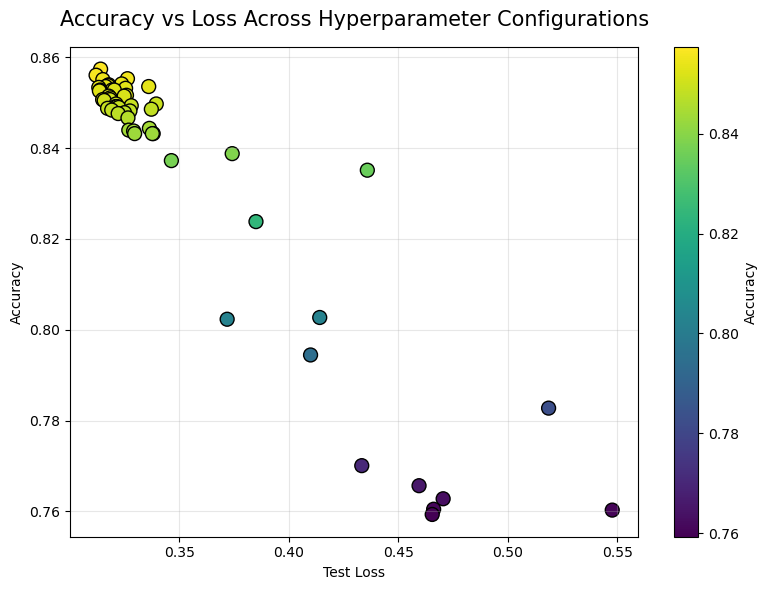

In [27]:
# Clara
# Plotting the accuracy and loss across different hyperparameters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(results_df['Test_Loss'], results_df['Accuracy'],
                      c=results_df['Accuracy'], cmap='viridis', s=100, edgecolor='k')

plt.colorbar(scatter, label="Accuracy")
plt.xlabel("Test Loss")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Loss Across Hyperparameter Configurations", fontsize=15, pad=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




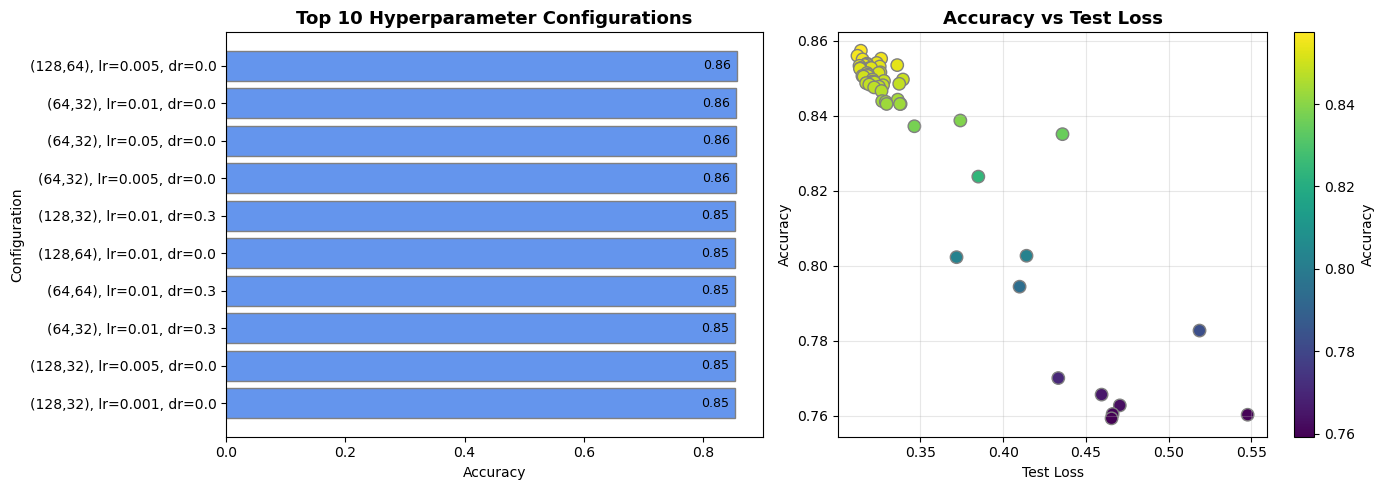

In [28]:
# Clara
# Just matplotlib shenanigans
import matplotlib.pyplot as plt

# Sort and take top 10
results_df = pd.DataFrame(results, columns=['Config', 'Test_Loss', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
top10 = results_df.head(10)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) # 1 row, two plots. 

# Top ten accuracies
axes[0].barh(top10['Config'], top10['Accuracy'], color='cornflowerblue', edgecolor='gray') # Make a horizontal bar chart.
axes[0].invert_yaxis()
axes[0].set_title("Top 10 Hyperparameter Configurations", fontsize=13, weight='bold')
axes[0].set_xlabel("Accuracy")
axes[0].set_ylabel("Configuration")

# Add text for all the accuracies
for i, v in enumerate(top10['Accuracy']):
    axes[0].text(v - 0.01, i, f"{v:.2f}", color='black', va='center', ha='right', fontsize=9) # Move the accuracy into the bar plot, hence the v - 0.01

# Accuracy vs the test losses
sc = axes[1].scatter(results_df['Test_Loss'], results_df['Accuracy'],
                     c=results_df['Accuracy'], cmap='viridis', s=80, edgecolor='gray')

axes[1].set_title("Accuracy vs Test Loss", fontsize=13, weight='bold')
axes[1].set_xlabel("Test Loss")
axes[1].set_ylabel("Accuracy")
axes[1].grid(alpha=0.3)
fig.colorbar(sc, ax=axes[1], label="Accuracy")

plt.tight_layout()
plt.show()


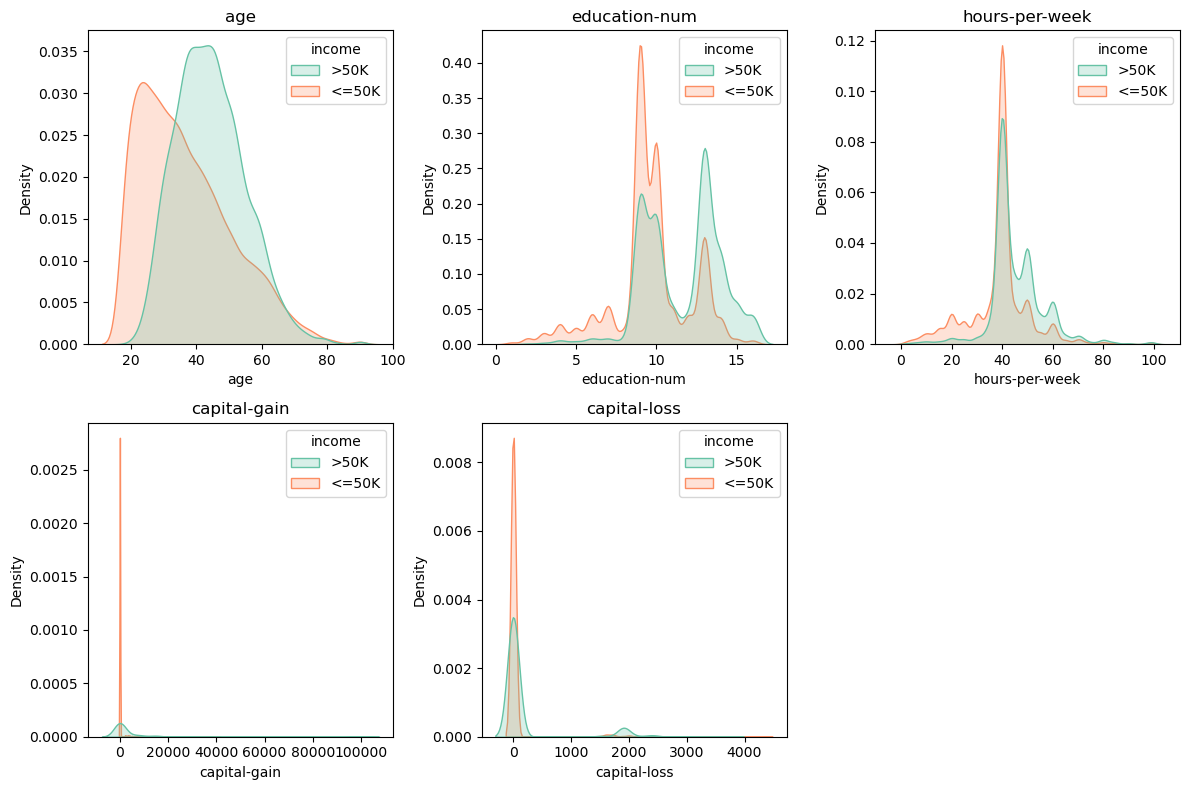

In [29]:
# Clara
# Uuuh, KDE plot. Why not? 
num_cols = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df, x=col, hue='income', fill=True, common_norm=False, palette='Set2')
    plt.title(col)
plt.tight_layout()
plt.show()

Best Model Configuration: (64, 32, 0.01, 0.0)


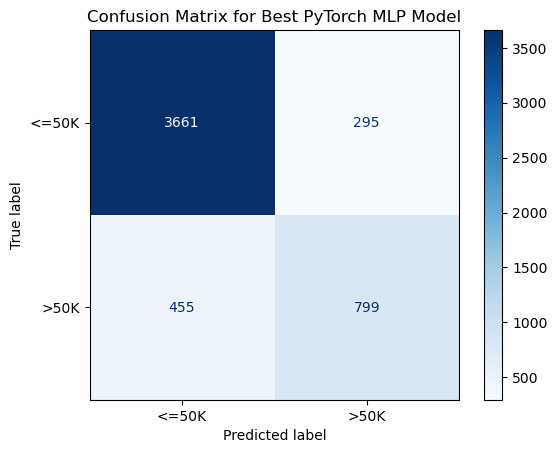

In [40]:
# Clara
# Safe conversion: handle both DataFrame and NumPy array inputs
X_test_arr = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Make predictions
y_pred = (
    best_model_pytorch(torch.tensor(X_test_arr, dtype=torch.float32))
    .detach().numpy() > 0.5
).astype(int)

# Print best model configuration
print(f"Best Model Configuration: {best_config}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Best PyTorch MLP Model")
plt.show()



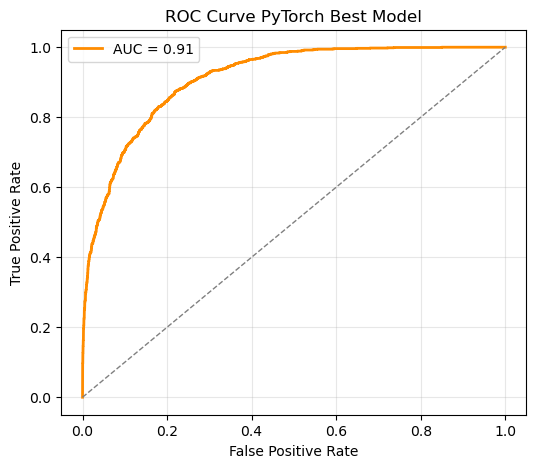

In [31]:
# Clara
# Handle both pandas DataFrames and NumPy arrays
X_test_arr = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Predict probabilities 
y_score = best_model_pytorch(torch.tensor(X_test_arr, dtype=torch.float32)).detach().numpy()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve PyTorch Best Model')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [32]:
# Clara and Carlie
# Clean column names
df_val.columns = (df_val.columns.str.strip()
                            .str.lower()
                            .str.replace(r'\s+', '-', regex=True)) # Any white space is replaced with a '-'. Don't be afraid. It's just regex. 

# One-hot encode using same columns as training
df_val = pd.get_dummies(df_val, columns=[c for c in categorical_cols if c in df_val.columns],
                        drop_first=True)

# Reindex to match the training feature space
df_val = df_val.reindex(columns=X_train_df.columns, fill_value=0)

# Scale numerical columns using the SAME scaler from training
df_val[numerical_cols] = scaler.transform(df_val[numerical_cols])

In [33]:
# Clara
# The Validation!
val_X_t = torch.tensor(df_val.values, dtype=torch.float32)

# Run the best model on the validation dataset
best_model_pytorch.eval()
with torch.no_grad():
    val_preds = best_model_pytorch(val_X_t).numpy().ravel()

# Probabilities to binary predictions
val_labels = (val_preds > 0.5).astype(int)

# Store the results
val_results = df_val.copy()
val_results["predicted_income"] = val_labels

# Print results
print(f"Predicted >50K count: {(val_labels == 1).sum()}")
print(f"Predicted <=50K count: {(val_labels == 0).sum()}")
print(f"Mean predicted probability: {val_preds.mean():.4f}")

val_results.head()

Predicted >50K count: 1400
Predicted <=50K count: 5113
Mean predicted probability: 0.2568


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,predicted_income
0,-0.851737,-0.277795,-0.033139,-0.145398,-0.219642,-0.190139,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0.469136,-1.313452,-0.420869,-0.145398,-0.219642,-0.027764,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,-0.704973,-0.034686,1.130051,-0.145398,-0.219642,1.190049,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.631591,0.004355,1.130051,-0.145398,-0.219642,-0.027764,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.704973,-0.002202,-0.033139,0.154899,-0.219642,0.784112,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
# Clara
print(best_model_pytorch)

Sequential(
  (0): Linear(in_features=97, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
  (6): Sigmoid()
)


Accuracy: 0.821
ROC AUC: 0.874

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3956
           1       0.61      0.69      0.65      1254

    accuracy                           0.82      5210
   macro avg       0.76      0.78      0.76      5210
weighted avg       0.83      0.82      0.82      5210



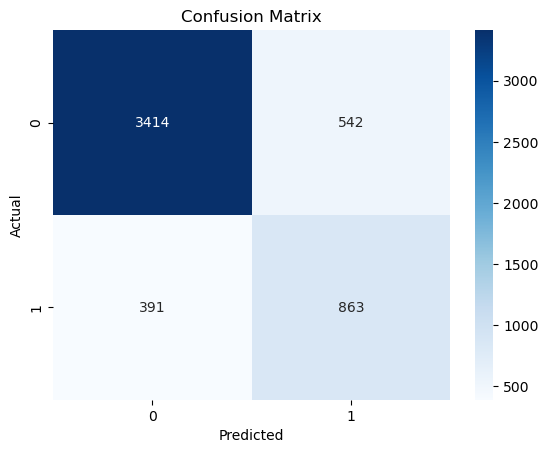

In [35]:
# Carlie
# Initial baseline model 
# Define and train MLP 
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# Fit the training data
mlp_clf.fit(X_train, y_train)

# Make predictions
y_pred = mlp_clf.predict(X_test)
y_prob = mlp_clf.predict_proba(X_test)[:, 1]  # for ROC/AUC

# Evaluate performance 
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
# Carlie
from sklearn.model_selection import GridSearchCV
#Using grid search to find best hyperparameters 
param_grid = {
    'hidden_layer_sizes': [(50,), (64, 32), (100,)], # Keys: the hyperparameters.
    'activation': ['relu', 'tanh'], # The values are the lists of the possibilities.
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01], # Kinds of regularization, basically
}

grid_search = GridSearchCV(
    MLPClassifier(max_iter=1000, random_state=42), # Cap at 1000 iterations, random state
    param_grid, # All the combinations to try
    scoring='roc_auc', # Use ROC for eval
    cv=5, # Five-fold cross validation
    n_jobs=-1, # Use all CPU cores
    verbose=2 # Print updates for every combination and fold. Just prints progress. 
)

# Print it all out
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation AUC:", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  17.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  19.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  19.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  20.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  20.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  26.4s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  16.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  20.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  20.5s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  26.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  19.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  21.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  39.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  28.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  36.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  39.5s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  37.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  33.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  38.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  41.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  30.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  14.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time=  38.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  23.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  47.0s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  47.7s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  45.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  45.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  21.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  45.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  21.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  25.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.4s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time=  21.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time=  30.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time=  18.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time=  15.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time=  19.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  39.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  40.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  43.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  33.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  42.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  37.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  43.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  42.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  24.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  13.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  34.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  20.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  40.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  14.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  45.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  19.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  47.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  48.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  48.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  20.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  28.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  15.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  16.0s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  14.5s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.5s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  27.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  17.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  25.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  32.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  41.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  42.0s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  42.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  40.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  31.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  42.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  28.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  23.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  21.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  42.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  42.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  44.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  47.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  38.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  46.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  41.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  42.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  27.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  31.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  31.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  33.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  33.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=adam; total time=  44.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  31.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.0min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  49.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  58.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  54.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time=  58.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  48.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  50.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.2min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  53.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  54.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time= 1.3min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  56.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time= 1.3min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=adam; total time= 1.4min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time= 1.0min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time= 1.0min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  41.7s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  56.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  30.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  56.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  47.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  45.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=adam; total time=  29.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  32.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  32.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  34.3s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  34.1s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), solver=lbfgs; total time=  33.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.2min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.1min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  56.8s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  56.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.2min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.0min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  56.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  53.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  54.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  48.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time=  58.0s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time= 1.0min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time= 1.2min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=adam; total time= 1.3min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  30.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  25.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  52.7s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  57.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  32.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time=  59.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  29.5s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), solver=lbfgs; total time= 1.1min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=adam; total time=  32.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  36.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  37.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  38.4s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  38.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), solver=lbfgs; total time=  37.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  57.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  56.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.2min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  55.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time=  59.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=adam; total time= 1.0min


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  54.4s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  53.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  43.2s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  49.7s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(64, 32), solver=lbfgs; total time=  51.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  42.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  47.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  50.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=adam; total time=  42.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  54.7s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  50.9s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  50.0s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  50.6s


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), solver=lbfgs; total time=  49.5s
Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Best Cross-Validation AUC: 0.8956545029861613


In [37]:
# Carlie
# Training MLP with best hyperparameters from grid search

best_mlp = MLPClassifier(
    activation='relu',
    alpha=0.01,
    hidden_layer_sizes=(50,), # 1 hidden layer, 50 neurons
    solver='adam',
    max_iter=2000, # Iterate for 2000.
    random_state=42
)
best_mlp.fit(X_train, y_train)


MLPClassifier(alpha=0.01, hidden_layer_sizes=(50,), max_iter=2000,
              random_state=42)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3956
           1       0.72      0.62      0.67      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.77      0.79      5210
weighted avg       0.85      0.85      0.85      5210

Accuracy: 0.8504798464491363
Test ROC AUC: 0.9045892375943996


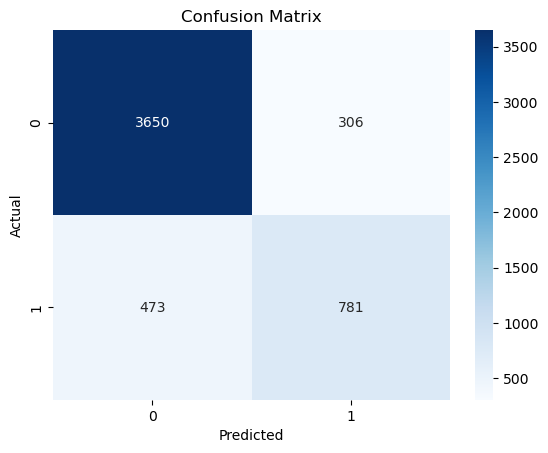

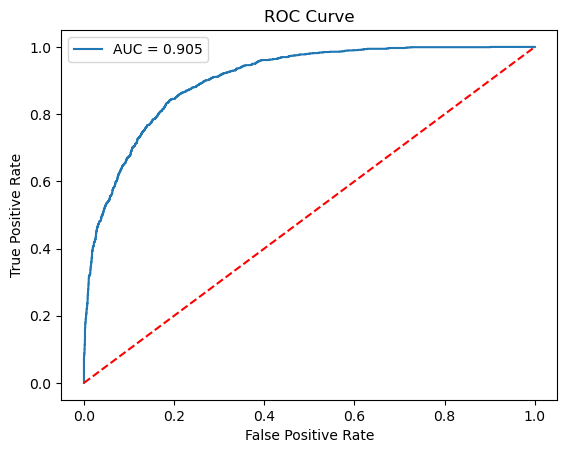

In [38]:
# Carlie
# Visualizing performance of the best model

y_pred = best_mlp.predict(X_test)
y_prob = best_mlp.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
accuracy_score = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score)
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
